In [1]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

import os
path = os.path.dirname(os.getcwd())
path = os.path.dirname(path)
path = os.path.join(path, "Daesamanlap/ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

In [4]:
## 1. EDA 및 전처리(baseline: MSE 98)

### 1) 상가비율

tmp = train.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
train = pd.merge(train,total[['단지코드','상가비율']],on='단지코드',how='left')

tmp = test.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
test = pd.merge(test,total[['단지코드','상가비율']],on='단지코드',how='left')

### 2) 세대당가능주차면수

train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

### 3) 공가비율

train['공가비율'] = train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['공가비율'] = test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)

### 4) 대형전용면적

level = 85

train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

### 5) 공급유형
#- 공공임대 5년/10년 $\rightarrow$ 공공임대(단기)

train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

#- 1차원으로 합치기

not_unique = ['공급유형','전용면적','임대건물구분','전용면적별세대수','대형전용면적','임대보증금','임대료','자격유형']

train_one = train.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)

#- 전용면적별세대수 채우기

for i in train['공급유형'].unique():
    train_one[i] = 0
    test_one[i] = 0

sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_one[train_one['단지코드']==code].index
    train_one.loc[ind,col] = val

sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_one[test_one['단지코드']==code].index
    test_one.loc[ind,col] = val

### 6) 임대료 임대보증금 : 평균

sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

### 연면적 / 전용면적은 나중에 drop

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2) # 12345 중에 2가 제일 좋음

sample = train.groupby('단지코드').mean()[['전용면적']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

sample = test.groupby('단지코드').mean()[['전용면적']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

train_one["연면적new"]=train_one.연면적
test_one["연면적new"]=test_one.연면적

train_one.loc[(train_one.연면적new<train_one.전용면적), "연면적new"]=np.nan
test_one.loc[(test_one.연면적new<test_one.전용면적), "연면적new"]=np.nan

#train_one.isna().sum() # 63

#test_one.isna().sum() #23

im=train_one[["단지내주차면수", "총세대수", "전용면적", "연면적new"]]
im = pd.DataFrame(imputer.fit_transform(im),
                     columns = im.columns)

train_one["연면적new"]=im["연면적new"]

imp=test_one[["단지내주차면수", "총세대수", "전용면적", "연면적new"]]
imp = pd.DataFrame(imputer.fit_transform(imp),
                     columns = imp.columns)

test_one["연면적new"]=imp["연면적new"]

### 7) 대형전용면적 총개수

sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
train_one = pd.merge(train_one, sample, on="단지코드", how="left")

sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
test_one = pd.merge(test_one, sample, on="단지코드", how="left")

### 8) 변수제거

col = ['단지명','도로명주소','subway_name','임대상가', '전용면적']

train_one = train_one.drop(col,axis=1)
test_one = test_one.drop(col,axis=1)

In [5]:
train_up = train_one[train_one['단지내주차면수']>=987].reset_index(drop=True)
train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)

test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

train_up_new = train_one[train_one['단지내주차면수']>=318].reset_index(drop=True)

In [6]:
def areafunc(x):
    if x in ['제주특별자치도','경상남도','부산광역시']:
        return 0
    elif x in ['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시']:
        return 1
    elif x in ['대구광역시']:
        return 2
    else: 
        return 3

In [7]:
train_up['지역'] = train_up['지역'].apply(lambda x : areafunc(x))
test_up['지역'] = test_up['지역'].apply(lambda x : areafunc(x))
train_up = train_up.join(pd.get_dummies(train_up['지역'],prefix='area')).iloc[:,:-1]
test_up = test_up.join(pd.get_dummies(test_up['지역'],prefix='area')).iloc[:,:-1]

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor


In [8]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
            print(model)
            print(best_error)
    best_tst_pred = sum(best_tst_pred,[])
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    
    return best_model, best_tst_pred, best_error

### 1) train/test down

In [9]:
X = train_down.drop(columns=['단지코드','등록차량수', "연면적new"],axis=1)
X = pd.get_dummies(X, drop_first=True) 
y = train_down['등록차량수']

In [12]:
models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
model_down,pred_down,error_down = fit_models(X, y, models, cv=True)
print('MAE : ',error_down)

105.37534703159452
MAE :  105.37534703159452


### 2) train up 

In [13]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            print(f"model:{str(m).split('(')[0]}\nMAE:{cv_error}")
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
    best_tst_pred = sum(best_tst_pred,[])
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

models = [
         CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
         LinearRegression(), 
          PLSRegression(), 
          Ridge(random_state=2021),
          Lasso(random_state=2021), 
          ElasticNet(random_state=2021),
          RandomForestRegressor(criterion="mae",random_state=2021),
          GradientBoostingRegressor(criterion="mae",random_state=2021)
         ]

In [14]:
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율', "연면적"],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수',  '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']]
y = train_up['등록차량수']

models = [
         CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
        
         ]
model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
print('MAE : ',error_up)

model:<catboost.core.CatBoostRegressor object at 0x7ffd30417340>
MAE:291.87954235273975
MAE :  291.87954235273975


In [15]:
best_tst_pred3 = pred_up
col = ["단지코드","단지내주차면수","총세대수","세대당_가능주차면수","상가비율","연면적","공가수","공가비율","임대보증금"]
tst_pred3 = pd.merge(pd.DataFrame(best_tst_pred3,index=[0]).T.reset_index(),
         pd.DataFrame(train_up[col].reset_index(drop=True)).reset_index(),
         on="index")
tst_pred3 = tst_pred3[tst_pred3.단지내주차면수>987]
tst_pred3 =pd.merge(tst_pred3,train_up[["등록차량수","단지코드"]], on = "단지코드", how = "inner")
mean_absolute_error(tst_pred3["등록차량수"], tst_pred3[0])

tmp = tst_pred3[["등록차량수",0]]
tmp.columns = ["등차","pred"]
tmp = tmp.sort_values("등차")

In [16]:
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율', "연면적"],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수',  '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']]
y = train_up['등록차량수']


In [89]:
np.max(X.연면적new)

31427.43

In [17]:
X.loc[X.연면적new>25000,"연면적new"]  = np.max(X.loc[X.연면적new<25000,"연면적new"] )*1
X.loc[X.임대보증금>100000000,"임대보증금"]  = np.max(X.loc[X.임대보증금<100000000,"임대보증금"] )*1
X.loc[X.subway_dist>1.2,"subway_dist"]  = np.max(X.loc[X.subway_dist<1.2,"subway_dist"] )*1

In [91]:
np.max(X.연면적new)

11191.17

In [18]:
models = [
          CatBoostRegressor(random_state=2021, loss_function = 'MAE')
         ]
model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
print('MAE : ',error_up)

model:<catboost.core.CatBoostRegressor object at 0x7ffd70494910>
MAE:293.33985126566256
MAE :  293.33985126566256


In [19]:
best_tst_pred3 = pred_up
col = ["단지코드","단지내주차면수","총세대수","세대당_가능주차면수","상가비율","연면적","공가수","공가비율","임대보증금"]
tst_pred3 = pd.merge(pd.DataFrame(best_tst_pred3,index=[0]).T.reset_index(),
         pd.DataFrame(train_up[col].reset_index(drop=True)).reset_index(),
         on="index")
tst_pred3 = tst_pred3[tst_pred3.단지내주차면수>987]
tst_pred3 =pd.merge(tst_pred3,train_up[["등록차량수","단지코드"]], on = "단지코드", how = "inner")
mean_absolute_error(tst_pred3["등록차량수"], tst_pred3[0])

tmp = tst_pred3[["등록차량수",0]]
tmp.columns = ["등차","pred"]
tmp = tmp.sort_values("등차")
tmp

,등차,pred
31,196.0,995.067895
47,579.0,1090.395831
10,619.0,950.858140
3,657.0,1040.288846
37,713.0,842.284853
44,733.0,1147.352289
41,783.0,1064.317170
34,795.0,897.795783
24,799.0,1370.649167
23,839.0,1095.551391


In [20]:
df=pd.merge(pd.DataFrame(pred_up,index=[0]).T.reset_index(),
        pd.DataFrame(train_up.단지코드.reset_index(drop=True)).reset_index(),
         on="index")

df=df.drop(columns=["index"])
df.columns=["pred_up", "단지코드"]

In [21]:
df=pd.merge(train_one, df, on="단지코드", how='inner')

In [22]:
df["diff"]=df.등록차량수-df.pred_up

<AxesSubplot:xlabel='diff', ylabel='Count'>

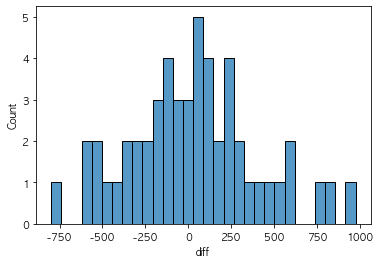

In [23]:
sns.histplot(df["diff"],bins = 30)

In [32]:
sum(np.abs(df["diff"])<150), sum(np.abs(df["diff"])>=150)

(19, 33)

In [34]:
df["label"]=0
df.loc[(df["diff"]<=150)&(df["diff"]>=-150), "label"]=1
df["label"].value_counts()

0    33
1    19
Name: label, dtype: int64

In [35]:
df_sm= df[["단지코드", "label"]]

In [45]:
train_sm= train_up.drop(columns=['지역','상가비율', "연면적"], axis=1)
train_sm = train_sm[['단지코드','등록차량수','총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수',  '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금' , '대형전용면적', 'area_0', 'area_1', 'area_2', ]]

In [46]:
train_sm= pd.merge(train_sm, df_sm, on="단지코드", how="inner")

In [47]:
X_sm= train_sm.drop(columns=['단지코드'], axis=1)
X_sm = train_sm[['등록차량수','총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수',  '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금' , '대형전용면적', 'area_0', 'area_1', 'area_2', ]]
y_sm= train_sm["label"]

In [48]:
X_sm.loc[X_sm.연면적new>25000,"연면적new"]  = np.max(X_sm.loc[X.연면적new<25000,"연면적new"] )*1
X_sm.loc[X_sm.임대보증금>100000000,"임대보증금"]  = np.max(X_sm.loc[X.임대보증금<100000000,"임대보증금"] )*1
X_sm.loc[X_sm.subway_dist>1.2,"subway_dist"]  = np.max(X_sm.loc[X.subway_dist<1.2,"subway_dist"] )*1

In [49]:
from imblearn.over_sampling import SMOTE
samp = SMOTE()
X_sm,y_sm = samp.fit_resample(X_sm,y_sm)
y_sm.value_counts()

1    33
0    33
Name: label, dtype: int64

In [50]:
y= X_sm["등록차량수"]
X= X_sm.drop(columns=['등록차량수'], axis=1)

In [51]:
models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
print('MAE : ',error_up)

model:<catboost.core.CatBoostRegressor object at 0x7ffd63feefd0>
MAE:233.89368026734564
MAE :  233.89368026734564


In [52]:
pred_=pd.DataFrame(pred_up,index=[0]).T

pred_=pred_.sort_index()

mean_absolute_error(pred_.iloc[0:51], y.iloc[0:51])

283.4262780942136

In [54]:
tmp = pd.concat([y.iloc[0:51],pred_],axis=1)
tmp.columns = ["등차","pred"]

In [57]:
tmp

,등차,pred
48,196.0,1024.349529
30,579.0,1142.300054
50,619.0,1073.741412
13,657.0,1174.276746
26,713.0,959.398031
...,...,...
61,NaN,1035.649690
62,NaN,1000.228637
63,NaN,1339.298756
64,NaN,1148.984287


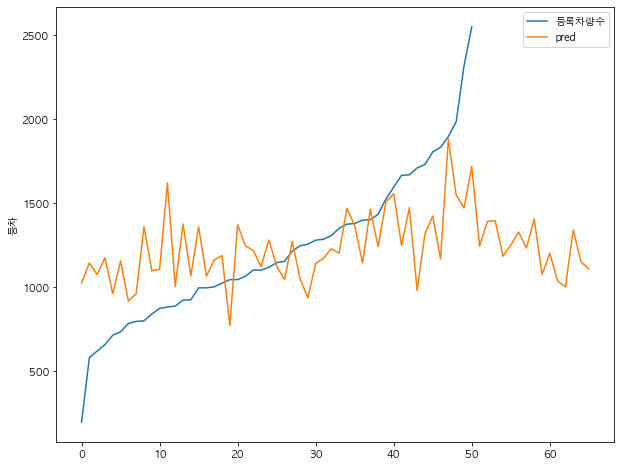

In [56]:
tmp = tmp.sort_values("등차")
plt.figure(figsize=(10,8))
sns.lineplot(x =range(len(tmp)),y = tmp.등차,label= "등록차량수")
sns.lineplot(x =range(len(tmp)),y = tmp.pred, label = "pred")
plt.legend()
plt.show()

In [112]:
sum(np.abs(tmp.등차-tmp.pred)<=200)

24

In [114]:
sum(np.abs(tmp.등차-tmp.pred)<=100)

11

In [113]:
len(tmp.등차)

52

In [100]:
from imblearn.over_sampling import SMOTE
samp = SMOTE()
X_sm,y_sm = samp.fit_resample(X,y)
y_sm.value_counts()

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 6

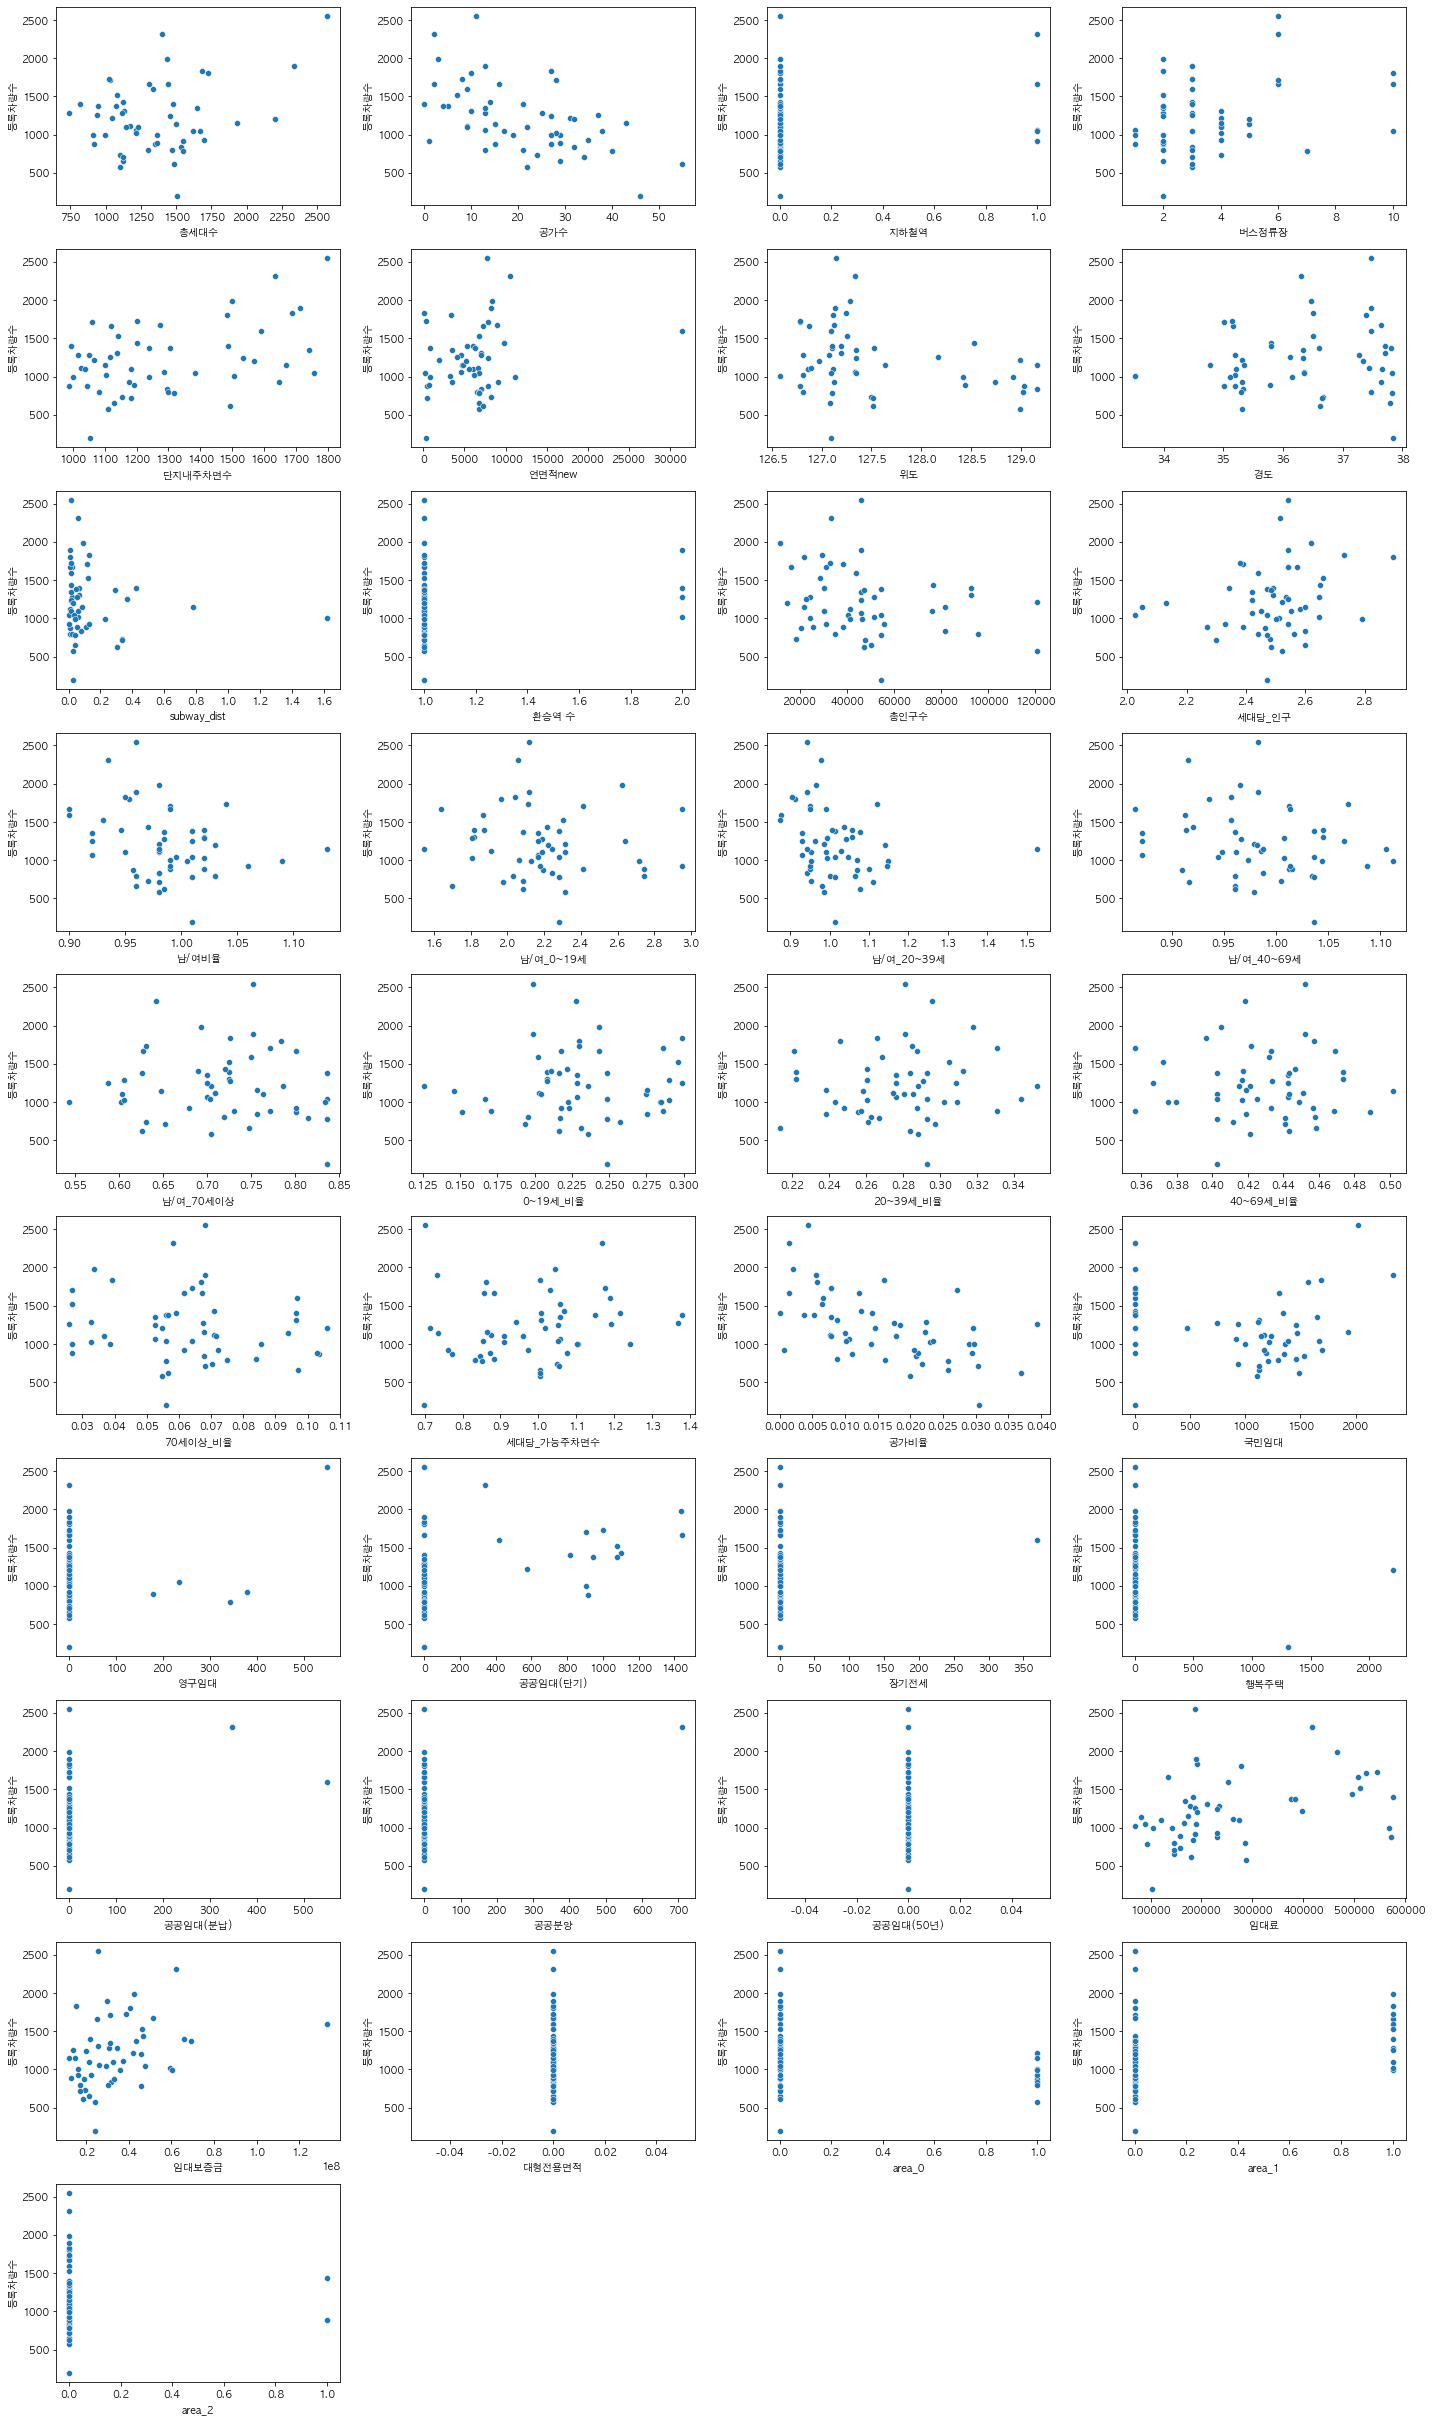

In [39]:
plt.figure(figsize=(20,40))
for i,r in enumerate (X.columns):
    plt.subplot(12,4,i+1)
    sns.scatterplot(X[r],y)
    plt.tight_layout()
    #plt.show()

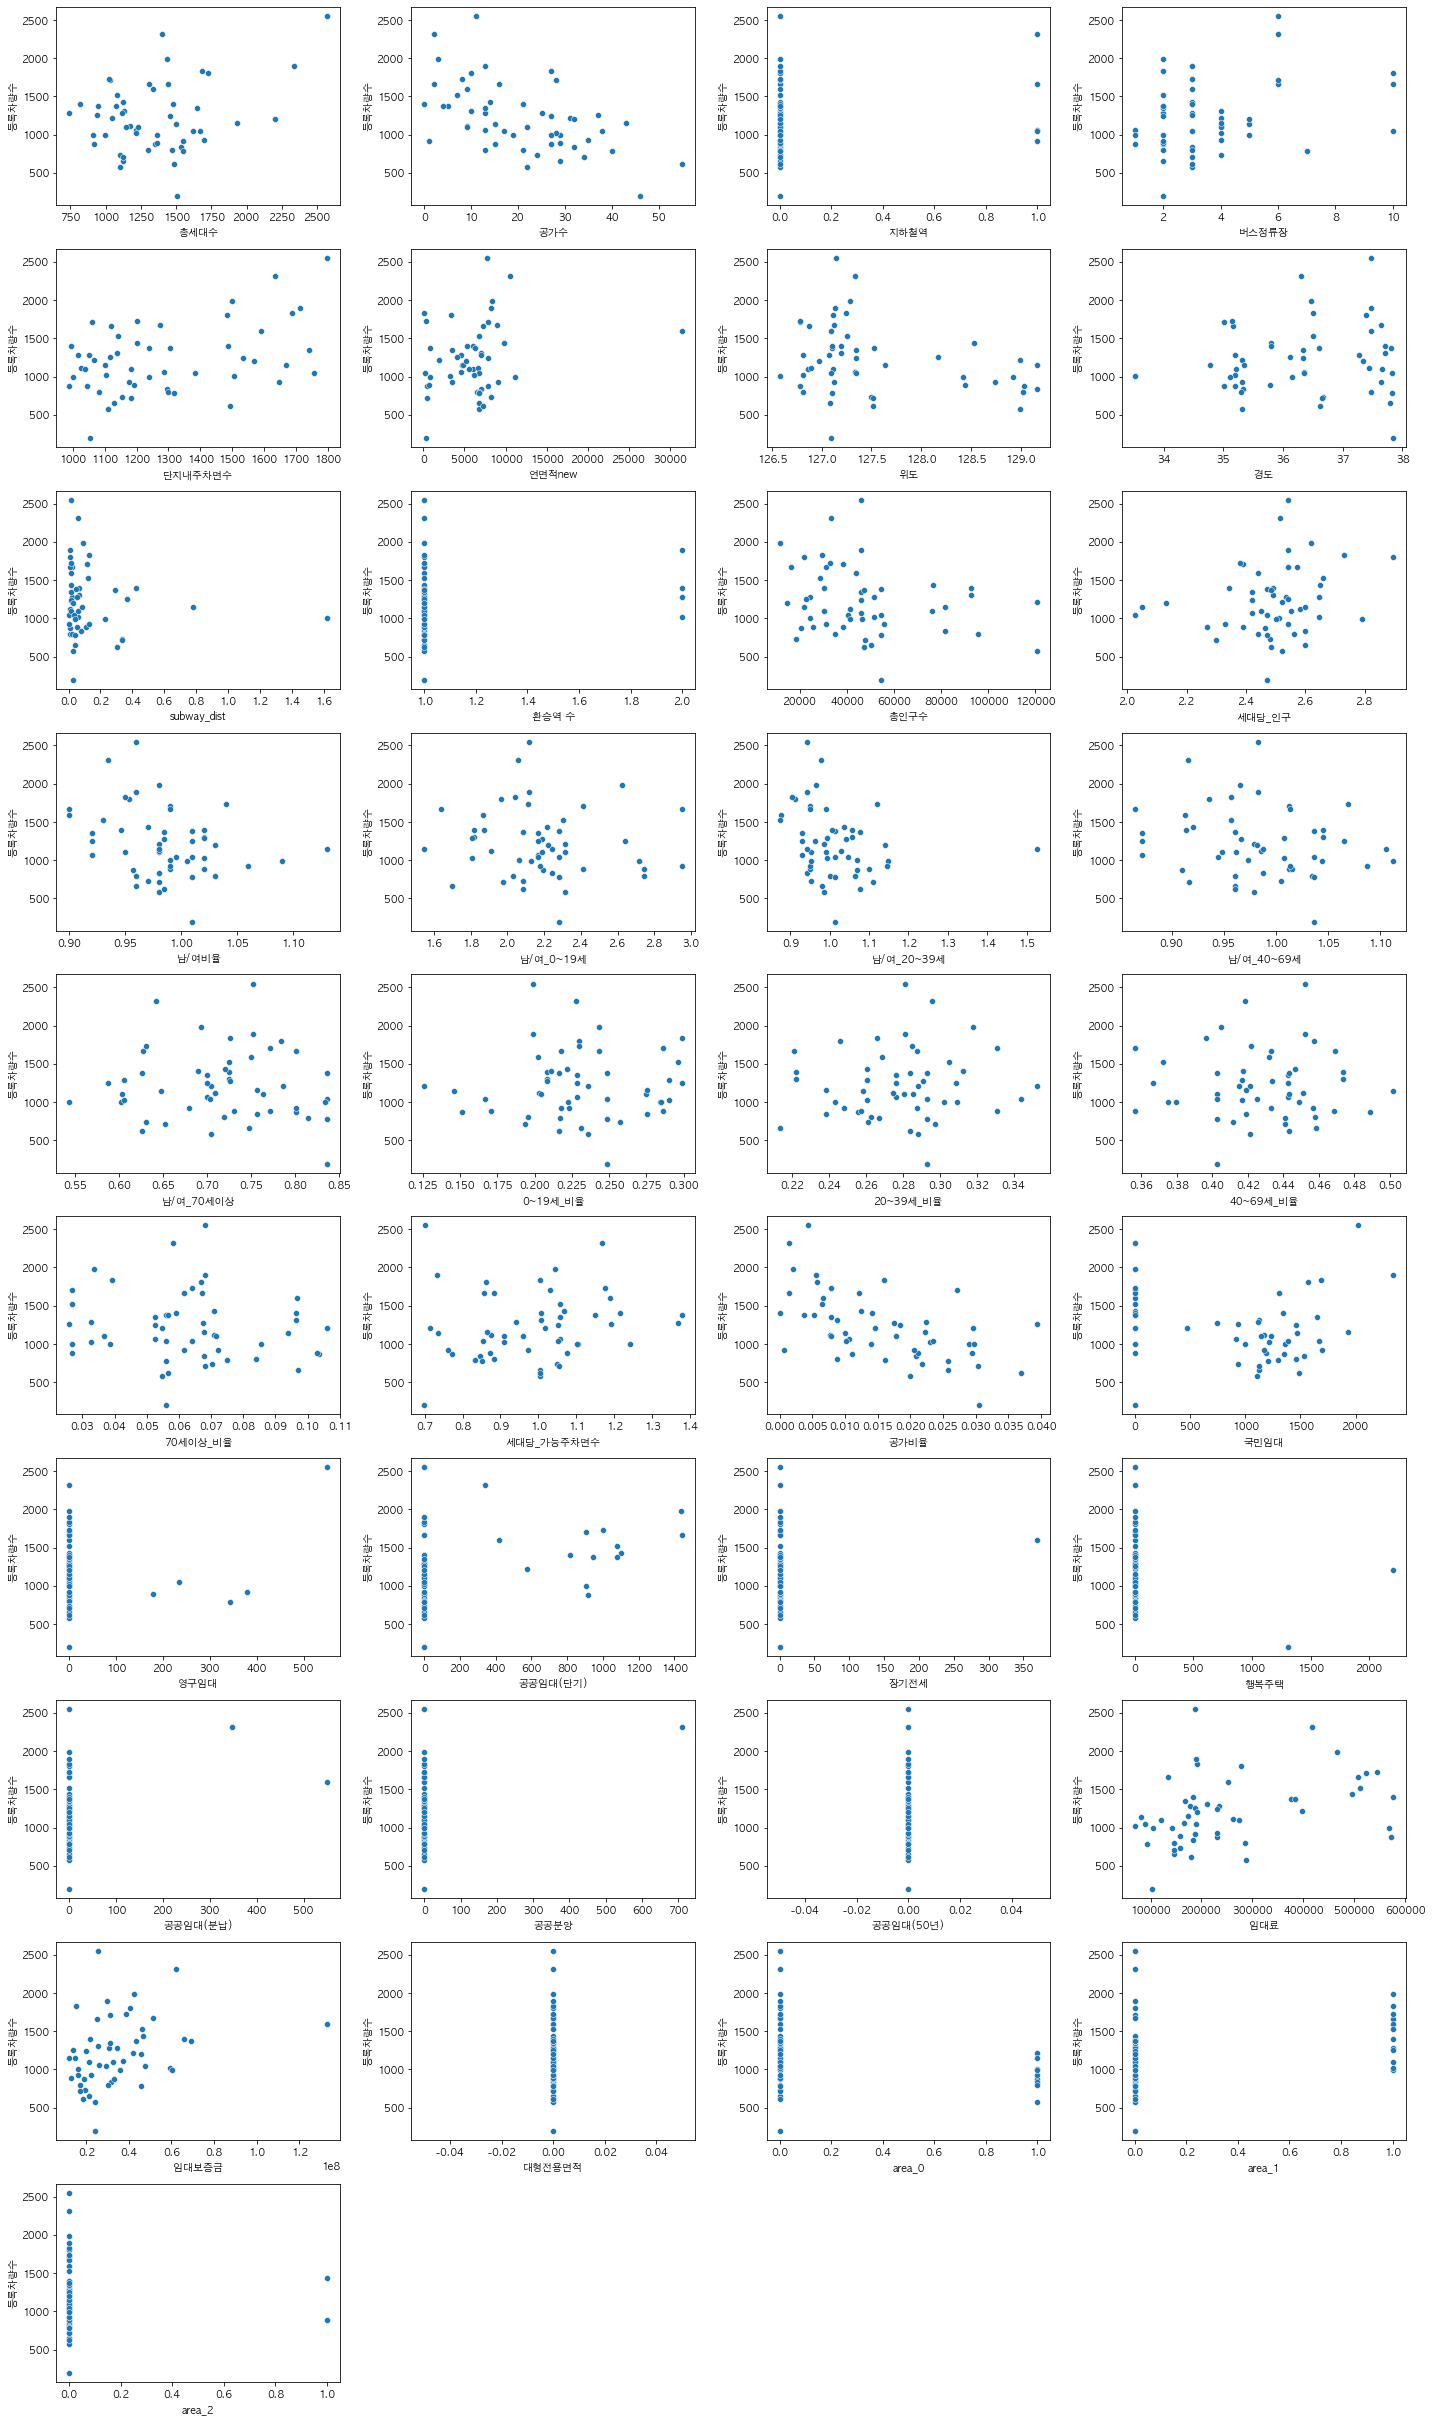

In [97]:
plt.figure(figsize=(20,40))
for i,r in enumerate (X.columns):
    plt.subplot(12,4,i+1)
    sns.scatterplot(X[r],y)
    plt.tight_layout()
    #plt.show()

In [49]:
# Fitting
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from xgboost import XGBRegressor
# import lightgbm as LGB
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error 

# Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold

In [94]:
models = [
          CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
         LinearRegression(), 
          PLSRegression(), 
          Ridge(random_state=2021),
          Lasso(random_state=2021), 
          ElasticNet(random_state=2021),
          RandomForestRegressor(criterion="mae",random_state=2021),
          GradientBoostingRegressor(criterion="mae",random_state=2021)
         ]
model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
print('MAE : ',error_up)

model:<catboost.core.CatBoostRegressor object at 0x7ffc804a5070>
MAE:291.87954235273975
model:LinearRegression
MAE:748.5636844675746
model:PLSRegression
MAE:296.05257596534534
model:Ridge
MAE:310.26967344803853
model:Lasso
MAE:259.39938539897076
model:ElasticNet
MAE:316.82278359017675
model:RandomForestRegressor
MAE:308.4618
model:GradientBoostingRegressor
MAE:346.66393454780064
MAE :  259.39938539897076


model:<catboost.core.CatBoostRegressor object at 0x7ffc73456190>
MAE:291.87954235273975
model:LinearRegression
MAE:748.5636844675746
model:PLSRegression
MAE:296.05257596534534
model:Ridge
MAE:310.26967344803853
model:Lasso
MAE:259.39938539897076
model:ElasticNet
MAE:316.82278359017675
model:RandomForestRegressor
MAE:308.4618
model:GradientBoostingRegressor
MAE:346.66393454780064
MAE :  259.39938539897076

In [93]:
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율', "연면적"],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수',  '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']]
y = train_up['등록차량수']

models = [Lasso(random_state=2021)]
model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
print('MAE : ',error_up)

model:Lasso
MAE:259.39938539897076
MAE :  259.39938539897076


In [95]:
best_tst_pred3 = pred_up
col = ["단지코드","단지내주차면수","총세대수","세대당_가능주차면수","상가비율","연면적","공가수","공가비율","임대보증금"]
tst_pred3 = pd.merge(pd.DataFrame(best_tst_pred3,index=[0]).T.reset_index(),
         pd.DataFrame(train_up[col].reset_index(drop=True)).reset_index(),
         on="index")
tst_pred3 = tst_pred3[tst_pred3.단지내주차면수>987]
tst_pred3 =pd.merge(tst_pred3,train_up[["등록차량수","단지코드"]], on = "단지코드", how = "inner")
mean_absolute_error(tst_pred3["등록차량수"], tst_pred3[0])

tmp = tst_pred3[["등록차량수",0]]
tmp.columns = ["등차","pred"]
tmp = tmp.sort_values("등차")

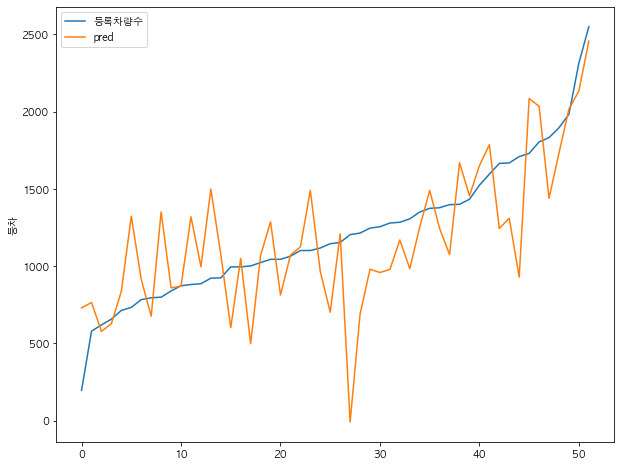

In [96]:
plt.figure(figsize=(10,8))
sns.lineplot(x =range(len(tmp)),y = tmp.등차,label= "등록차량수")
sns.lineplot(x =range(len(tmp)),y = tmp.pred, label = "pred")
plt.legend()
plt.show()

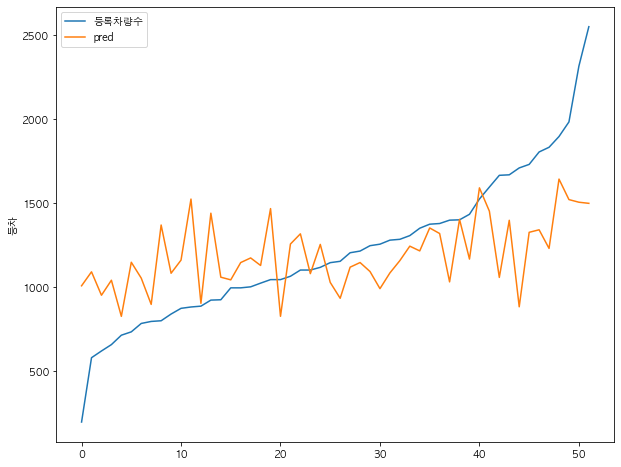

In [23]:
plt.figure(figsize=(10,8))
sns.lineplot(x =range(len(tmp)),y = tmp.등차,label= "등록차량수")
sns.lineplot(x =range(len(tmp)),y = tmp.pred, label = "pred")
plt.legend()
plt.show()